In [70]:
!pip install pandas
!pip install sentence-transformers
!pip install umap-learn
!pip install bertopic
!pip install nbformat
!pip install ipykernel
!pip install --upgrade nbformat




[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [71]:
import pandas as pd
import sentence_transformers
from sentence_transformers import SentenceTransformer
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from itertools import combinations

In [72]:
# set sns plot 
sns.set_theme()
sns.set_theme(style="whitegrid")
sns.set_context("talk")
plt.rcParams.update({'font.size': 14}) 


In [73]:
df = pd.read_csv("../../Dataset/tweets/transformed_final.csv")
df = df.rename(columns={"batch": "Batch"})
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [74]:

model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')
clean_embs = model.encode(df['cleaned_transform'].tolist())
groq_embs = model.encode(df['transformed_tweets_groq'].tolist())
gemini_embs = model.encode(df['transformed_tweets_gemini'].tolist())
gpt_embs = model.encode(df['transformed_tweets_gpt'].tolist())
deepseek_embs = model.encode(df['transformed_tweets_deepseek'].tolist())

model_outputs = {
    "Original": (df["cleaned_transform"].tolist(), clean_embs),
    "Groq": (df["transformed_tweets_groq"].tolist(), groq_embs),
    "GPT": (df["transformed_tweets_gpt"].tolist(), gpt_embs),
    "Gemini": (df["transformed_tweets_gemini"].tolist(), gemini_embs),
    "DeepSeek": (df["transformed_tweets_deepseek"].tolist(), deepseek_embs)
}


In [76]:
data = []
versions = ['Orig', 'Groq', 'GPT', 'Gem', 'DS']
all_embs = {
    'Orig': clean_embs,
    'Groq': groq_embs,
    'GPT': gpt_embs,
    'Gem': gemini_embs,
    'DS': deepseek_embs,

}


for i in range(len(df)):
    row = {'Batch': df['Batch'][i]}
    for v1, v2 in combinations(versions, 2):
        sim = cosine_similarity([all_embs[v1][i]], [all_embs[v2][i]])[0][0]
        row[f'{v1} vs {v2}'] = sim
    data.append(row)


In [77]:
semantic_df = pd.DataFrame(data)

In [78]:
semantic_df

,Batch,Orig vs Groq,Orig vs GPT,Orig vs Gem,Orig vs DS,Groq vs GPT,Groq vs Gem,Groq vs DS,GPT vs Gem,GPT vs DS,Gem vs DS
0,1,0.586812,0.618557,0.621310,0.601447,0.848012,0.574727,0.736910,0.640047,0.847292,0.697336
1,1,0.383714,0.626996,0.543842,0.588157,0.637355,0.514002,0.631639,0.695270,0.967343,0.683968
2,1,0.509619,0.578746,0.602767,0.694710,0.703136,0.696615,0.787204,0.738665,0.874023,0.819371
3,1,0.518724,0.558992,0.707070,0.611048,0.791903,0.580149,0.799937,0.692040,0.870538,0.703375
4,1,0.427090,0.603940,0.405413,0.596159,0.668931,0.436037,0.699158,0.479846,0.903807,0.521278
...,...,...,...,...,...,...,...,...,...,...,...
395,20,0.586521,0.724633,0.658230,0.694058,0.795705,0.706056,0.836440,0.734437,0.838809,0.855950
396,20,0.574353,0.798330,0.628526,0.717690,0.702934,0.705845,0.743631,0.735851,0.879118,0.805187
397,20,0.788065,0.833329,0.823366,0.836354,0.848971,0.808909,0.890102,0.841906,0.969833,0.867972
398,20,0.851801,0.847862,0.851893,0.841348,0.984293,0.884254,0.973286,0.901220,0.978178,0.879657


Semantic Analysis

In [79]:
semantic_df

,Batch,Orig vs Groq,Orig vs GPT,Orig vs Gem,Orig vs DS,Groq vs GPT,Groq vs Gem,Groq vs DS,GPT vs Gem,GPT vs DS,Gem vs DS
0,1,0.586812,0.618557,0.621310,0.601447,0.848012,0.574727,0.736910,0.640047,0.847292,0.697336
1,1,0.383714,0.626996,0.543842,0.588157,0.637355,0.514002,0.631639,0.695270,0.967343,0.683968
2,1,0.509619,0.578746,0.602767,0.694710,0.703136,0.696615,0.787204,0.738665,0.874023,0.819371
3,1,0.518724,0.558992,0.707070,0.611048,0.791903,0.580149,0.799937,0.692040,0.870538,0.703375
4,1,0.427090,0.603940,0.405413,0.596159,0.668931,0.436037,0.699158,0.479846,0.903807,0.521278
...,...,...,...,...,...,...,...,...,...,...,...
395,20,0.586521,0.724633,0.658230,0.694058,0.795705,0.706056,0.836440,0.734437,0.838809,0.855950
396,20,0.574353,0.798330,0.628526,0.717690,0.702934,0.705845,0.743631,0.735851,0.879118,0.805187
397,20,0.788065,0.833329,0.823366,0.836354,0.848971,0.808909,0.890102,0.841906,0.969833,0.867972
398,20,0.851801,0.847862,0.851893,0.841348,0.984293,0.884254,0.973286,0.901220,0.978178,0.879657


In [81]:
grouped = semantic_df.groupby('Batch').agg(['mean', 'std'])
grouped.reset_index()

Batch Orig vs Groq           Orig vs GPT           Orig vs Gem            \
                 mean       std        mean       std        mean       std   
0      1     0.501112  0.187356    0.604938  0.151233    0.585695  0.192548   
1      2     0.512716  0.213207    0.613592  0.168912    0.625214  0.122728   
2      3     0.542320  0.185662    0.591814  0.161564    0.552258  0.188573   
3      4     0.506583  0.130678    0.591692  0.133970    0.615272  0.126030   
4      5     0.521632  0.165714    0.622697  0.151218    0.565694  0.192536   
5      6     0.423620  0.208239    0.484575  0.184365    0.504074  0.207336   
6      7     0.515772  0.153159    0.586822  0.174086    0.564370  0.165837   
7      8     0.477692  0.215200    0.460691  0.209026    0.461169  0.189516   
8      9     0.352105  0.186322    0.456579  0.207169    0.536016  0.207097   
9     10     0.593568  0.131755    0.602931  0.121525    0.603461  0.185381   
10    11     0.436348  0.237036    0.537613  0.224309    0.498168  0.205833   
11    12     0.434575  0.248524    0.539877  0.215815    0.550637  0.206382   
12    13     0.517852  0.200593    0.620778  0.156110    0.625230  0.163874   
13    14     0.463721  0.226846    0.514266  0.219916    0.526803  0.178985   
14    15     0.455938  0.245821    0.543276  0.221568    0.554481  0.210288   
15    16     0.634111  0.135105    0.670643  0.141201    0.670160  0.123849   
16    17     0.561016  0.160679    0.619349  0.164444    0.628442  0.170794   
17    18     0.599272  0.189902    0.650919  0.182532    0.655829  0.171892   
18    19     0.598643  0.193206    0.609185  0.193862    0.605509  0.168657   
19    20     0.628611  0.115802    0.712777  0.151347    0.710174  0.113221   

   Orig vs DS           Groq vs GPT  ... Groq vs Gem           Groq vs DS  \
         mean       std        mean  ...        mean       std       mean   
0    0.609118  0.179024    0.713963  ...    0.534512  0.196949   0.724327   
1    0.618620  0.188578    0.673335  ...    0.562825  0.166788   0.694129   
2    0.550328  0.183201    0.741210  ...    0.581654  0.158261   0.752387   
3    0.587745  0.169633    0.754649  ...    0.600597  0.140533   0.780643   
4    0.606009  0.149990    0.701083  ...    0.534220  0.205942   0.705034   
5    0.510696  0.205267    0.638299  ...    0.483204  0.213710   0.665256   
6    0.572507  0.166862    0.704527  ...    0.532761  0.184296   0.727496   
7    0.486751  0.192678    0.603027  ...    0.454036  0.219926   0.615347   
8    0.447631  0.218709    0.693427  ...    0.416442  0.180877   0.696908   
9    0.580199  0.197012    0.750370  ...    0.639002  0.162028   0.765201   
10   0.503419  0.216009    0.650985  ...    0.471953  0.280617   0.652283   
11   0.563559  0.215743    0.615515  ...    0.536653  0.249573   0.670720   
12   0.645172  0.158713    0.693090  ...    0.609972  0.177554   0.693351   
13   0.496388  0.214418    0.666562  ...    0.550763  0.194119   0.674853   
14   0.537170  0.231825    0.653646  ...    0.520360  0.240945   0.692179   
15   0.669334  0.153470    0.812706  ...    0.691523  0.117769   0.809758   
16   0.645004  0.187021    0.718897  ...    0.571619  0.130827   0.746302   
17   0.687409  0.191274    0.717378  ...    0.646853  0.122923   0.731215   
18   0.630310  0.197755    0.740335  ...    0.579845  0.197092   0.776820   
19   0.709090  0.122643    0.812578  ...    0.688960  0.109250   0.824233   

             GPT vs Gem           GPT vs DS           Gem vs DS            
         std       mean       std      mean       std      mean       std  
0   0.165757   0.624936  0.152865  0.816470  0.121413  0.642131  0.179539  
1   0.193501   0.579865  0.109841  0.811371  0.119190  0.617217  0.124352  
2   0.099316   0.585597  0.151206  0.828949  0.122335  0.547785  0.167948  
3   0.095489   0.639890  0.118484  0.832439  0.120725  0.610912  0.153366  
4   0.179478   0.583947  0.199553  0.836267  0.095232  0.583272  0.229383  
5   0.225524   0.500359  0.194436  0.

In [82]:
semantic_long = pd.melt(semantic_df, id_vars="Batch", var_name="Comparison", value_name="Similarity")

In [83]:
semantic_long

,Batch,Comparison,Similarity
0,1,Orig vs Groq,0.586812
1,1,Orig vs Groq,0.383714
2,1,Orig vs Groq,0.509619
3,1,Orig vs Groq,0.518724
4,1,Orig vs Groq,0.427090
...,...,...,...
3995,20,Gem vs DS,0.855950
3996,20,Gem vs DS,0.805187
3997,20,Gem vs DS,0.867972
3998,20,Gem vs DS,0.879657


In [84]:
original = semantic_long[semantic_long['Comparison'].str.contains("Orig")]
other = semantic_long[~semantic_long['Comparison'].str.contains("Orig")]

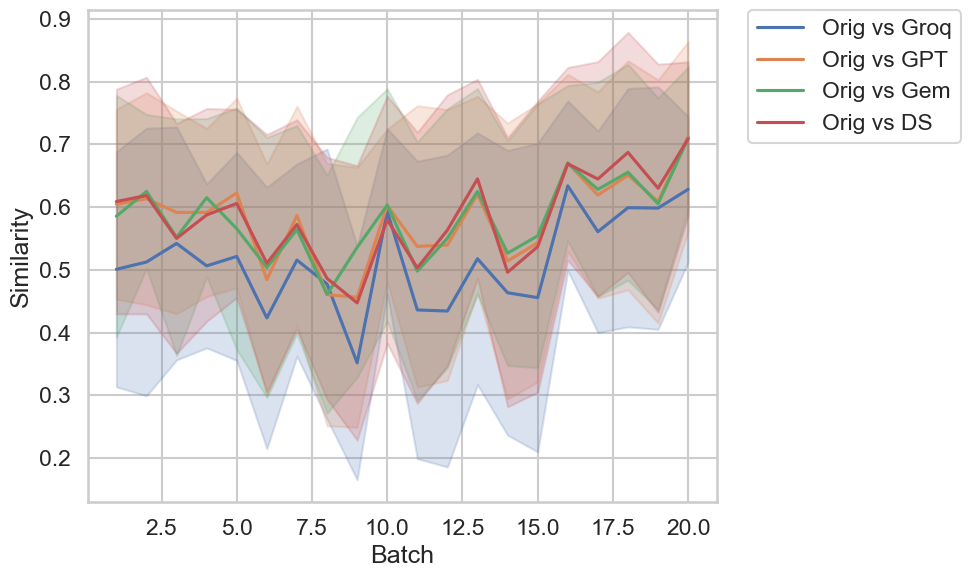

In [ ]:
plt.figure(figsize=(10, 6))
ax = sns.lineplot(original, x="Batch", y="Similarity", hue="Comparison")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

plt.tight_layout()  
plt.show()

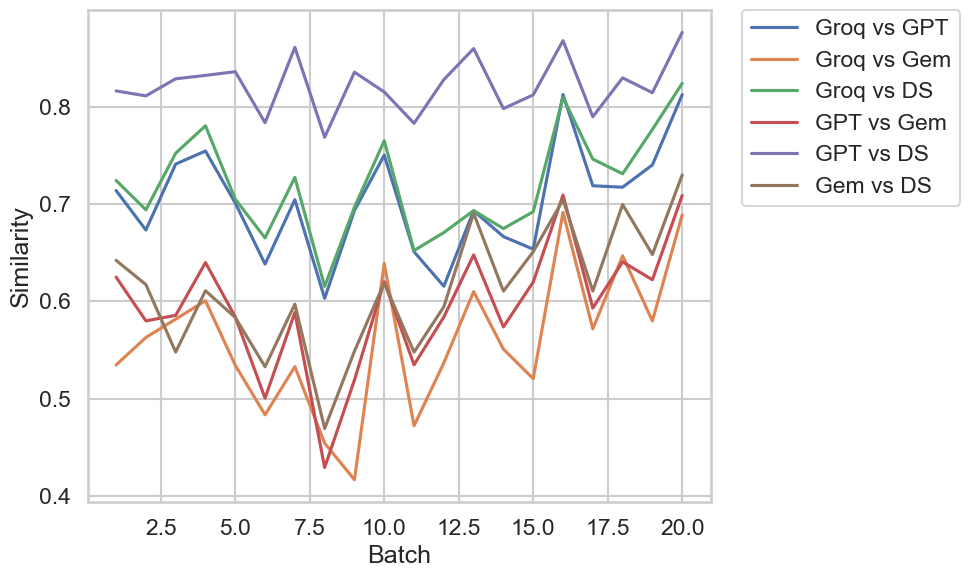

In [86]:
plt.figure(figsize=(10, 6))
ax = sns.lineplot(other, x="Batch", y="Similarity", hue="Comparison", ci=None)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

plt.tight_layout() 
plt.show()

In [87]:
semantic_long

,Batch,Comparison,Similarity
0,1,Orig vs Groq,0.586812
1,1,Orig vs Groq,0.383714
2,1,Orig vs Groq,0.509619
3,1,Orig vs Groq,0.518724
4,1,Orig vs Groq,0.427090
...,...,...,...
3995,20,Gem vs DS,0.855950
3996,20,Gem vs DS,0.805187
3997,20,Gem vs DS,0.867972
3998,20,Gem vs DS,0.879657


In [88]:
semantic_long = semantic_long.sort_values(ascending=True, by="Comparison")

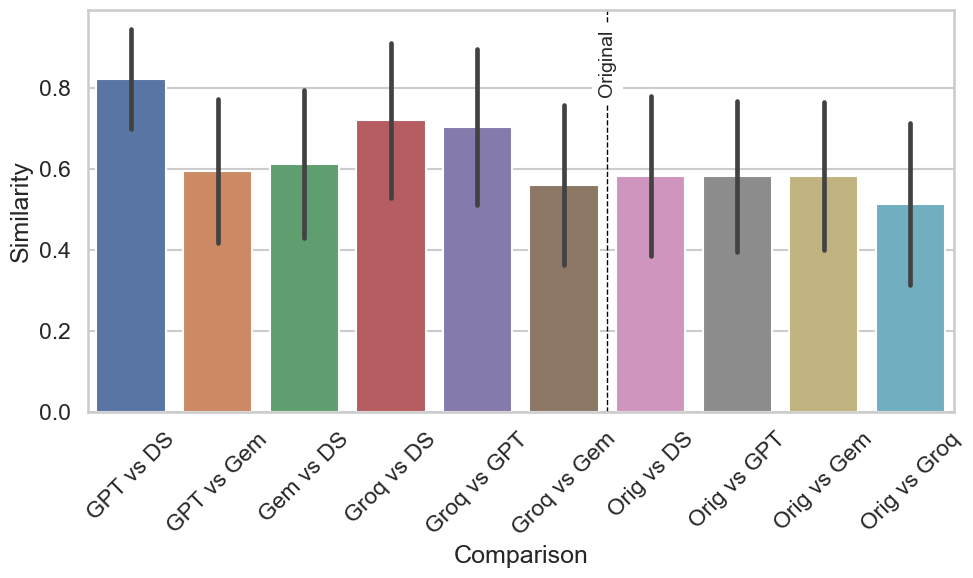

In [89]:
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=semantic_long, 
    x="Comparison", 
    y="Similarity", 
    hue="Comparison", 
    errorbar="sd", 
    dodge=False  
)



# add vertical line
ax.axvline(x=5.5, color='black', linestyle='--', linewidth=1)  # x=5.5 is between 6th and 7th bar (0-based index)

# add text
plt.text(5.5, plt.ylim()[1] * 0.95, 'Original', 
         ha='center', va='top', rotation=90, backgroundcolor='white')


plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [92]:
comparisons = semantic_df.drop(columns="Batch")
means = comparisons.mean().round(3)
stds = comparisons.std().round(3)
print(means)
print(stds)

Orig vs Groq    0.514
Orig vs GPT     0.582
Orig vs Gem     0.582
Orig vs DS      0.583
Groq vs GPT     0.703
Groq vs Gem     0.560
Groq vs DS      0.720
GPT vs Gem      0.595
GPT vs DS       0.823
Gem vs DS       0.613
dtype: float32
Orig vs Groq    0.200
Orig vs GPT     0.187
Orig vs Gem     0.183
Orig vs DS      0.197
Groq vs GPT     0.193
Groq vs Gem     0.197
Groq vs DS      0.191
GPT vs Gem      0.178
GPT vs DS       0.123
Gem vs DS       0.183
dtype: float32


In [93]:
rows = []
for model_name, embeddings in all_embs.items():
    for i, emb in enumerate(embeddings):
        rows.append({
            'batch': i,
            'model': model_name,
            'embedding': emb
        })

# Create a DataFrame
df_embs = pd.DataFrame(rows)

# Now split out the embedding into columns
emb_array = np.vstack(df_embs['embedding'].values)  # shape: (n_rows, 768)
emb_df = pd.DataFrame(emb_array, columns=[f'dim_{i}' for i in range(emb_array.shape[1])])



In [94]:
df_embs

,batch,model,embedding
0,0,Orig,"[-0.037697844, -0.025611673, -0.0060677277, -0..."
1,1,Orig,"[0.05442989, 0.005573005, 0.014092423, -0.0159..."
2,2,Orig,"[0.03023139, 0.074154384, -0.012508403, -0.001..."
3,3,Orig,"[-0.022994034, 0.01440142, 0.00840599, 0.00480..."
4,4,Orig,"[-0.011766515, 0.024291381, 0.00078020076, -0...."
...,...,...,...
1995,395,DS,"[0.055408016, 0.07320115, 0.0015605988, 0.0430..."
1996,396,DS,"[0.018758195, 0.08574585, -0.0061674914, -0.01..."
1997,397,DS,"[-0.01644467, 0.11668765, 0.028108152, -0.0011..."
1998,398,DS,"[0.027419923, 0.056523018, -0.008913566, 0.041..."


In [95]:
emb_array

array([[-0.03769784, -0.02561167, -0.00606773, ...,  0.00105824,
         0.00153819,  0.0022844 ],
       [ 0.05442989,  0.005573  ,  0.01409242, ..., -0.01589041,
         0.04202234, -0.03802771],
       [ 0.03023139,  0.07415438, -0.0125084 , ..., -0.02168244,
        -0.03579484, -0.03444018],
       ...,
       [-0.01644467,  0.11668765,  0.02810815, ...,  0.04289521,
        -0.08183977,  0.02333216],
       [ 0.02741992,  0.05652302, -0.00891357, ...,  0.01409639,
         0.03543568, -0.02389295],
       [ 0.04739507, -0.00910918, -0.00202207, ...,  0.03303381,
        -0.02020888, -0.02727645]], shape=(2000, 768), dtype=float32)

In [96]:
emb_df

,dim_0,dim_1,dim_2,dim_3,dim_4,dim_5,dim_6,dim_7,dim_8,dim_9,...,dim_758,dim_759,dim_760,dim_761,dim_762,dim_763,dim_764,dim_765,dim_766,dim_767
0,-0.037698,-0.025612,-0.006068,-0.012583,-0.043684,0.009731,0.072474,-0.016563,0.008406,0.018894,...,-0.002317,0.017066,0.001029,0.027745,-0.006859,-0.054434,0.004385,0.001058,0.001538,0.002284
1,0.054430,0.005573,0.014092,-0.015948,-0.052359,0.015184,0.029534,0.008037,-0.040867,0.000364,...,-0.001009,0.015071,-0.013012,-0.004968,-0.004884,0.007130,0.042996,-0.015890,0.042022,-0.038028
2,0.030231,0.074154,-0.012508,-0.001534,-0.041149,0.064024,0.025404,0.025417,0.046546,0.016978,...,-0.014737,0.071352,0.011899,-0.020535,-0.018791,-0.041160,-0.006128,-0.021682,-0.035795,-0.034440
3,-0.022994,0.014401,0.008406,0.004807,-0.052965,0.045664,0.050944,-0.032005,0.052582,0.013904,...,-0.018963,0.019709,0.045775,-0.036437,-0.012722,-0.016921,0.019363,0.017042,-0.024432,0.030440
4,-0.011767,0.024291,0.000780,-0.038392,0.004186,0.020650,0.031552,-0.008352,0.035285,0.027966,...,-0.010874,0.020087,0.020614,-0.067253,-0.012083,-0.031762,0.010930,-0.002616,-0.054534,0.009840
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0.055408,0.073201,0.001561,0.043079,-0.034740,0.036118,0.018688,-0.018413,-0.000839,0.008663,...,-0.026901,0.008316,-0.014322,0.051552,-0.020506,-0.067240,-0.019379,0.009445,0.066252,0.026766
1996,0.018758,0.085746,-0.006167,-0.012517,-0.006818,0.039896,-0.037285,0.015616,0.022274,-0.057424,...,0.005793,0.072796,0.043469,-0.047665,-0.024572,0.016733,-0.076992,-0.053938,-0.010475,-0.027746
1997,-0.016445,0.116688,0.028108,-0.001191,-0.030996,0.014284,0.080041,-0.001890,0.065821,0.023241,...,-0.043971,0.026033,-0.002928,0.034184,-0.023556,-0.102087,-0.055058,0.042895,-0.081840,0.023332
1998,0.027420,0.056523,-0.008914,0.041570,0.026770,0.023458,0.068237,-0.035204,-0.012560,-0.013301,...,0.021275,0.038176,0.017272,-0.000290,-0.021409,-0.026427,-0.023537,0.014096,0.035436,-0.023893


In [97]:
import umap.umap_ as umap
reducer = umap.UMAP()
embedding = reducer.fit_transform(emb_array)
embedding.shape

(2000, 2)

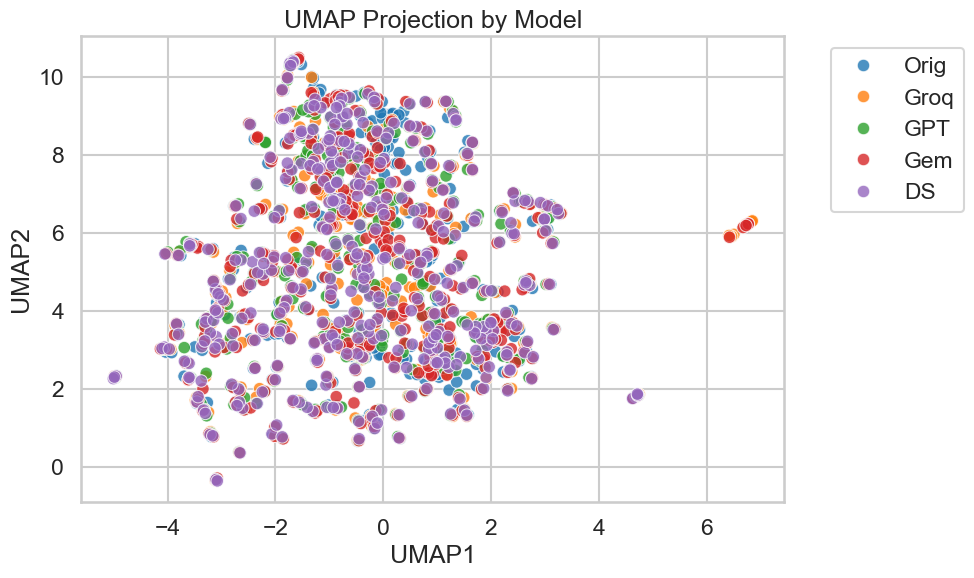

In [98]:
umap_df = pd.DataFrame(embedding, columns=['UMAP1', 'UMAP2'])
umap_df['model'] = df_embs['model'].values  # or 'batch' if preferred

# Step 2: Plot with Seaborn
plt.figure(figsize=(10, 6))
sns.scatterplot(data=umap_df, x='UMAP1', y='UMAP2', hue='model', palette='tab10', alpha=0.8)
plt.title('UMAP Projection by Model')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()